<div class="alert alert-block alert-info" style="margin-top: 20px">
<h1 >Customer Lifetime Value Prediction</h1>
<p>Data Preperation </p>
<p>Calculate Expected Sale Forecasting values with <strong>BG-NBD Model.</strong> </p>
<p>Calculate Expected Average Profit values with <strong>Gamma-Gamma Model.</strong></p>
<p>Calculate CLTV for a specified time period with <strong>BG-NBD and Gamma-Gamma models.</strong> </p>
</div>

In [6]:
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
from helpers import *
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [4]:
df_ = pd.read_excel("online_retail_II.xlsx",
                    sheet_name="Year 2010-2011")

In [19]:
df = df_.copy()

In [20]:
check_df(df)

##################### Shape #####################
(541910, 8)
##################### Types #####################
Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
dtype: object
##################### Head #####################
  Invoice StockCode                         Description  Quantity  \
0  536365    85123A  WHITE HANGING HEART T-LIGHT HOLDER         6   
1  536365     71053                 WHITE METAL LANTERN         6   
2  536365    84406B      CREAM CUPID HEARTS COAT HANGER         8   

          InvoiceDate   Price  Customer ID         Country  
0 2010-12-01 08:26:00 2.55000  17850.00000  United Kingdom  
1 2010-12-01 08:26:00 3.39000  17850.00000  United Kingdom  
2 2010-12-01 08:26:00 2.75000  17850.00000  United Kingdom  
##################### NA #####################
Invoice          

In [21]:
# 1. Data Preperation
# Drop NA's
df.dropna(axis=0, inplace=True)
# C means refundees, drop them
df = df[~df["Invoice"].str.contains("C", na=False)]
# there shouldn't be quantity value as zero
df = df[df["Quantity"] > 0]
# Replace outliers with threshold (0.99-0.01)
replace_with_thresholds(df, "Quantity")
replace_with_thresholds(df, "Price")
# Creating TotalPrice feature
df["TotalPrice"] = df["Quantity"] * df["Price"]
df["TotalPrice"] = df["Quantity"] * df["Price"]
today_date = dt.datetime(2011, 12, 11)

# RFM

In [22]:
rfm = df.groupby('Customer ID').agg({'InvoiceDate': [lambda date: (date.max() - date.min()).days,
                                                     lambda date: (today_date - date.min()).days],
                                     'Invoice': lambda num: num.nunique(),
                                     'TotalPrice': lambda TotalPrice: TotalPrice.sum()})

In [23]:
rfm.head()

InvoiceDate             Invoice TotalPrice
             <lambda_0> <lambda_1> <lambda>   <lambda>
Customer ID                                           
12346.00000           0        326        1  310.44000
12347.00000         365        368        7 4310.00000
12348.00000         282        359        4 1770.78000
12349.00000           0         19        1 1491.72000
12350.00000           0        311        1  331.46000

In [24]:
rfm.columns = rfm.columns.droplevel(0)
rfm.columns = ['recency_cltv_p', 'T', 'frequency', 'monetary']

In [25]:
rfm["monetary"] = rfm["monetary"] / rfm["frequency"]
rfm.rename(columns={"monetary": "monetary_avg"}, inplace=True)

In [26]:
rfm.head()

,recency_cltv_p,T,frequency,monetary_avg
Customer ID,,,,
12346.00000,0,326,1,310.44000
12347.00000,365,368,7,615.71429
12348.00000,282,359,4,442.69500
12349.00000,0,19,1,1491.72000
12350.00000,0,311,1,331.46000


In [27]:
## recency_weekly_p
rfm["recency_weekly_p"] = rfm["recency_cltv_p"] / 7 # haftalığa çevirdik.
rfm["T_weekly"] = rfm["T"] / 7

In [28]:
# CONTROL
rfm = rfm[rfm["monetary_avg"] > 0]

In [29]:
# No correlation between Monetary and Frequency for BG / NBD Model 
rfm[['monetary_avg', 'recency_weekly_p']].corr()

,monetary_avg,recency_weekly_p
monetary_avg,1.00000,0.07186
recency_weekly_p,0.07186,1.00000


In [30]:
## freq > 1
rfm = rfm[(rfm['frequency'] > 1)]
rfm["frequency"] = rfm["frequency"].astype(int)

# 2.Creating BG / NBD Model
- Forecast of expected sales
- It is performed over frequency, weekly recency and weekly tenure. (may be monthly instead of weekly) 

In [32]:
bgf = BetaGeoFitter(penalizer_coef=0.001)

bgf.fit(rfm['frequency'],
        rfm['recency_weekly_p'],
        rfm['T_weekly'])

<lifetimes.BetaGeoFitter: fitted with 2845 subjects, a: 0.12, alpha: 11.40, b: 2.49, r: 2.18>

### Who are the top 10 customers we expect to buy in 1 week?

In [47]:
bgf.conditional_expected_number_of_purchases_up_to_time(1,
                                                        rfm['frequency'],
                                                        rfm['recency_weekly_p'],
                                                        rfm['T_weekly']).sort_values(ascending=False).head(10)

Customer ID
12748.00000   3.26516
14911.00000   3.12664
17841.00000   1.94029
13089.00000   1.53753
14606.00000   1.46400
15311.00000   1.43372
12971.00000   1.35702
14646.00000   1.22252
13408.00000   0.98625
18102.00000   0.96861
dtype: float64

In [48]:
rfm["expected_number_of_purchases"] = bgf.predict(1,
                                                  rfm['frequency'],
                                                  rfm['recency_weekly_p'],
                                                  rfm['T_weekly'])

rfm.head()

,recency_cltv_p,T,frequency,monetary_avg,recency_weekly_p,T_weekly,expected_number_of_purchases
Customer ID,,,,,,,
12347.00000,365,368,7,615.71429,52.14286,52.57143,0.14128
12348.00000,282,359,4,442.69500,40.28571,51.28571,0.09196
12352.00000,260,297,8,219.54250,37.14286,42.42857,0.18240
12356.00000,302,326,3,937.14333,43.14286,46.57143,0.08616
12358.00000,149,151,2,575.21000,21.28571,21.57143,0.12226


### Who are the top 10 customers we expect to buy in 1 month?

In [51]:
bgf.predict(4,
            rfm['frequency'],
            rfm['recency_weekly_p'],
            rfm['T_weekly']).sort_values(ascending=False).head(10)

Customer ID
12748.00000   13.02567
14911.00000   12.47310
17841.00000    7.74034
13089.00000    6.13346
14606.00000    5.84027
15311.00000    5.71947
12971.00000    5.41348
14646.00000    4.87636
13408.00000    3.93437
18102.00000    3.86386
dtype: float64

In [52]:
rfm["expected_number_of_purchases"] = bgf.predict(4,
                                                  rfm['frequency'],
                                                  rfm['recency_weekly_p'],
                                                  rfm['T_weekly'])

In [53]:
rfm.sort_values("expected_number_of_purchases", ascending=False).head(10)

,recency_cltv_p,T,frequency,monetary_avg,recency_weekly_p,T_weekly,expected_number_of_purchases
Customer ID,,,,,,,
12748.00000,372,374,210,154.19243,53.14286,53.42857,13.02567
14911.00000,372,374,201,691.71010,53.14286,53.42857,12.47310
17841.00000,371,374,124,330.13435,53.00000,53.42857,7.74034
13089.00000,366,370,97,606.36247,52.28571,52.85714,6.13346
14606.00000,372,374,93,130.13903,53.14286,53.42857,5.84027
15311.00000,373,374,91,667.77912,53.28571,53.42857,5.71947
12971.00000,368,373,86,127.48587,52.57143,53.28571,5.41348
14646.00000,353,355,74,3596.80439,50.42857,50.71429,4.87636
13408.00000,371,374,62,453.50065,53.00000,53.42857,3.93437


### What is the Expected Sales of the whole Company in 1 Month? 

In [54]:
bgf.predict(4,
            rfm['frequency'],
            rfm['recency_weekly_p'],
            rfm['T_weekly']).sum()

1777.1450731636864

### What is the Expected Sales Number of the Whole Company in 3 Months? 

In [55]:
bgf.predict(4 * 3,
            rfm['frequency'],
            rfm['recency_weekly_p'],
            rfm['T_weekly']).sum()

5271.849715637076

In [57]:
### Evaluation of Estimation Results 

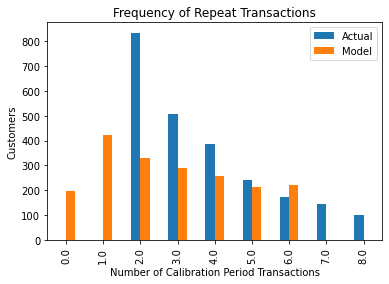

In [58]:
plot_period_transactions(bgf)
plt.show()

# 3. Creating the GAMMA-GAMMA Model
- Expected average profitability.
- It is done using # frequency and monetary_avg variables. 

In [60]:
ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(rfm['frequency'], rfm['monetary_avg'])

ggf.conditional_expected_average_profit(rfm['frequency'],
                                        rfm['monetary_avg']).head(10)

Customer ID
12347.00000    631.91197
12348.00000    463.74554
12352.00000    224.88667
12356.00000    995.99768
12358.00000    631.90095
12359.00000   1435.03722
12360.00000    933.78938
12362.00000    532.23164
12363.00000    304.26377
12364.00000    344.13665
dtype: float64

In [61]:
ggf.conditional_expected_average_profit(rfm['frequency'],
                                        rfm['monetary_avg']).sort_values(ascending=False).head(10)

Customer ID
12415.00000   5772.17719
12590.00000   5029.40987
12435.00000   4288.93571
12409.00000   3918.80790
14088.00000   3917.12864
18102.00000   3870.99670
12753.00000   3678.57611
14646.00000   3605.30916
15749.00000   3216.04831
14096.00000   3196.43538
dtype: float64

In [63]:
rfm["expected_average_profit"] = ggf.conditional_expected_average_profit(rfm['frequency'],
                                                                         rfm['monetary_avg'])

In [65]:
rfm.sort_values("expected_average_profit", ascending=False).head(10)

,recency_cltv_p,T,frequency,monetary_avg,recency_weekly_p,T_weekly,expected_number_of_purchases,expected_average_profit
Customer ID,,,,,,,,
12415.00000,313,338,21,5724.30262,44.71429,48.28571,1.51398,5772.17719
12590.00000,0,212,2,4591.17250,0.00000,30.28571,0.04593,5029.40987
12435.00000,188,268,2,3914.94500,26.85714,38.28571,0.30407,4288.93571
12409.00000,103,183,3,3690.89000,14.71429,26.14286,0.46741,3918.80790
14088.00000,312,323,13,3864.55462,44.57143,46.14286,1.03796,3917.12864
18102.00000,366,368,60,3859.73908,52.28571,52.57143,3.86386,3870.99670
12753.00000,339,363,6,3571.56500,48.42857,51.85714,0.50277,3678.57611
14646.00000,353,355,74,3596.80439,50.42857,50.71429,4.87636,3605.30916
15749.00000,97,333,3,3028.78000,13.85714,47.57143,0.11156,3216.04831


# 4. Calculation of CLTV with BG-NBD and GG model. 

In [67]:
cltv = ggf.customer_lifetime_value(bgf,
                                   rfm['frequency'],
                                   rfm['recency_weekly_p'],
                                   rfm['T_weekly'],
                                   rfm['monetary_avg'],
                                   time=3,  # 3 months
                                   freq="W",  # T' frequency information.
                                   discount_rate=0.01)

In [68]:
cltv.head()

Customer ID
12347.00000   1128.46141
12348.00000    538.79801
12352.00000    517.51478
12356.00000   1083.05929
12358.00000    966.68008
Name: clv, dtype: float64

In [69]:
cltv.shape
cltv = cltv.reset_index()

In [71]:
cltv.sort_values(by="clv", ascending=False).head(10)

,Customer ID,clv
1122,14646.00000,55722.42033
2761,18102.00000,47415.67007
843,14096.00000,29066.03859
36,12415.00000,27686.52225
1257,14911.00000,27379.34142
2458,17450.00000,27167.74056
874,14156.00000,23425.86127
2487,17511.00000,18987.67667
2075,16684.00000,13441.17488
650,13694.00000,12966.94100


In [72]:
rfm_cltv_final = rfm.merge(cltv, on="Customer ID", how="left")

In [73]:
rfm_cltv_final.head()

,Customer ID,recency_cltv_p,T,frequency,monetary_avg,recency_weekly_p,T_weekly,expected_number_of_purchases,expected_average_profit,clv
0,12347.00000,365,368,7,615.71429,52.14286,52.57143,0.56352,631.91197,1128.46141
1,12348.00000,282,359,4,442.69500,40.28571,51.28571,0.36675,463.74554,538.79801
2,12352.00000,260,297,8,219.54250,37.14286,42.42857,0.72713,224.88667,517.51478
3,12356.00000,302,326,3,937.14333,43.14286,46.57143,0.34351,995.99768,1083.05929
4,12358.00000,149,151,2,575.21000,21.28571,21.57143,0.48623,631.90095,966.68008
